In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('realty.csv', index_col=['date'])
prices.head(10)

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
03-01-2018  258.299988     710.750000     479.600006     618.250000   
04-01-2018  257.500000     714.750000     487.450012     580.599976   
05-01-2018  259.950012     725.250000     489.700012     575.099976   
08-01-2018  260.250000     736.950012     493.450012     585.650024   
09-01-2018  269.850006     791.549988     506.700012     602.549988   
10-01-2018  269.350006     826.349976     528.000000     589.500000   
11-01-2018  270.500000     844.599976     555.250000     606.650024   
12-01-2018  268.549988     834.750000     532.700012     595.250000   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
03-01-2018   321.000000  205.300003    216.000000  603.250000  414.450012  
04-01-2018   338.600006  205.100006    219.250000  610.000000  415.600006  
05-01-2018   335.049988  205.500000    221.250000  605.549988  413.149994  
08-01-2018   332.399994  209.000000    229.250000  599.799988  413.399994  
09-01-2018   333.750000  208.533341    235.850006  606.000000  409.750000  
10-01-2018   334.049988  208.100006    247.100006  604.400024  409.899994  
11-01-2018   345.000000  210.199997    255.649994  605.349976  406.549988  
12-01-2018   337.950012  210.266663    253.600006  592.400024  404.700012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
30-12-2020  235.949997    1393.750000     567.950012     763.049988   
31-12-2020  232.850006    1432.150024     583.400024     774.549988   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
30-12-2020   264.899994  246.100006     79.300003  382.500000  356.049988  
31-12-2020   266.100006  249.100006     82.199997  414.649994  347.950012

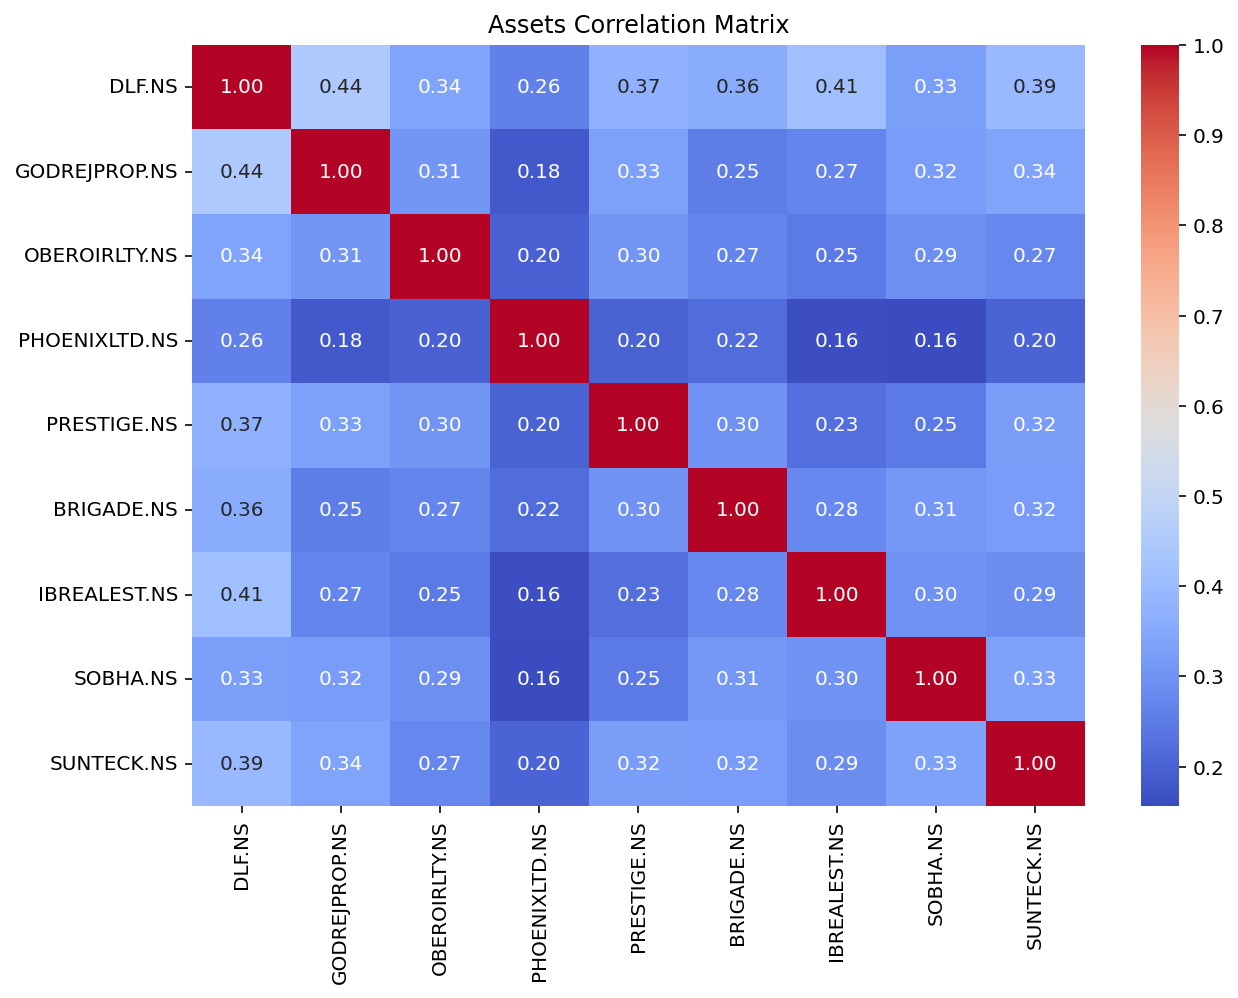

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DLF.NS', 'OBEROIRLTY.NS'), ('OBEROIRLTY.NS', 'PRESTIGE.NS'), ('OBEROIRLTY.NS', 'SOBHA.NS'), ('OBEROIRLTY.NS', 'SUNTECK.NS'), ('PHOENIXLTD.NS', 'PRESTIGE.NS'), ('PHOENIXLTD.NS', 'BRIGADE.NS')]


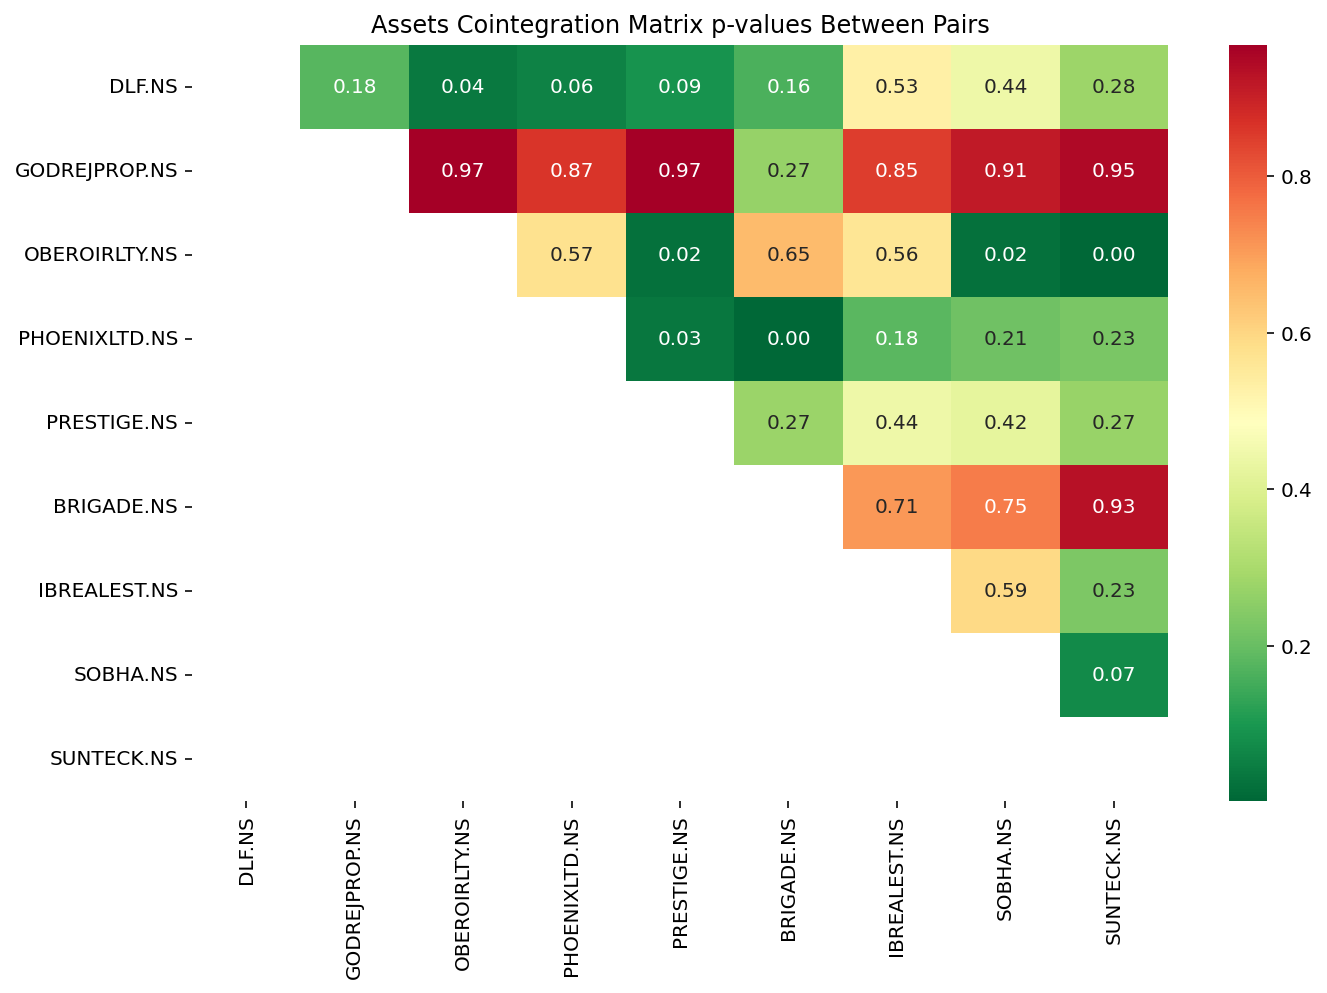

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'OBEROIRLTY.NS'
asset2 = 'SUNTECK.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

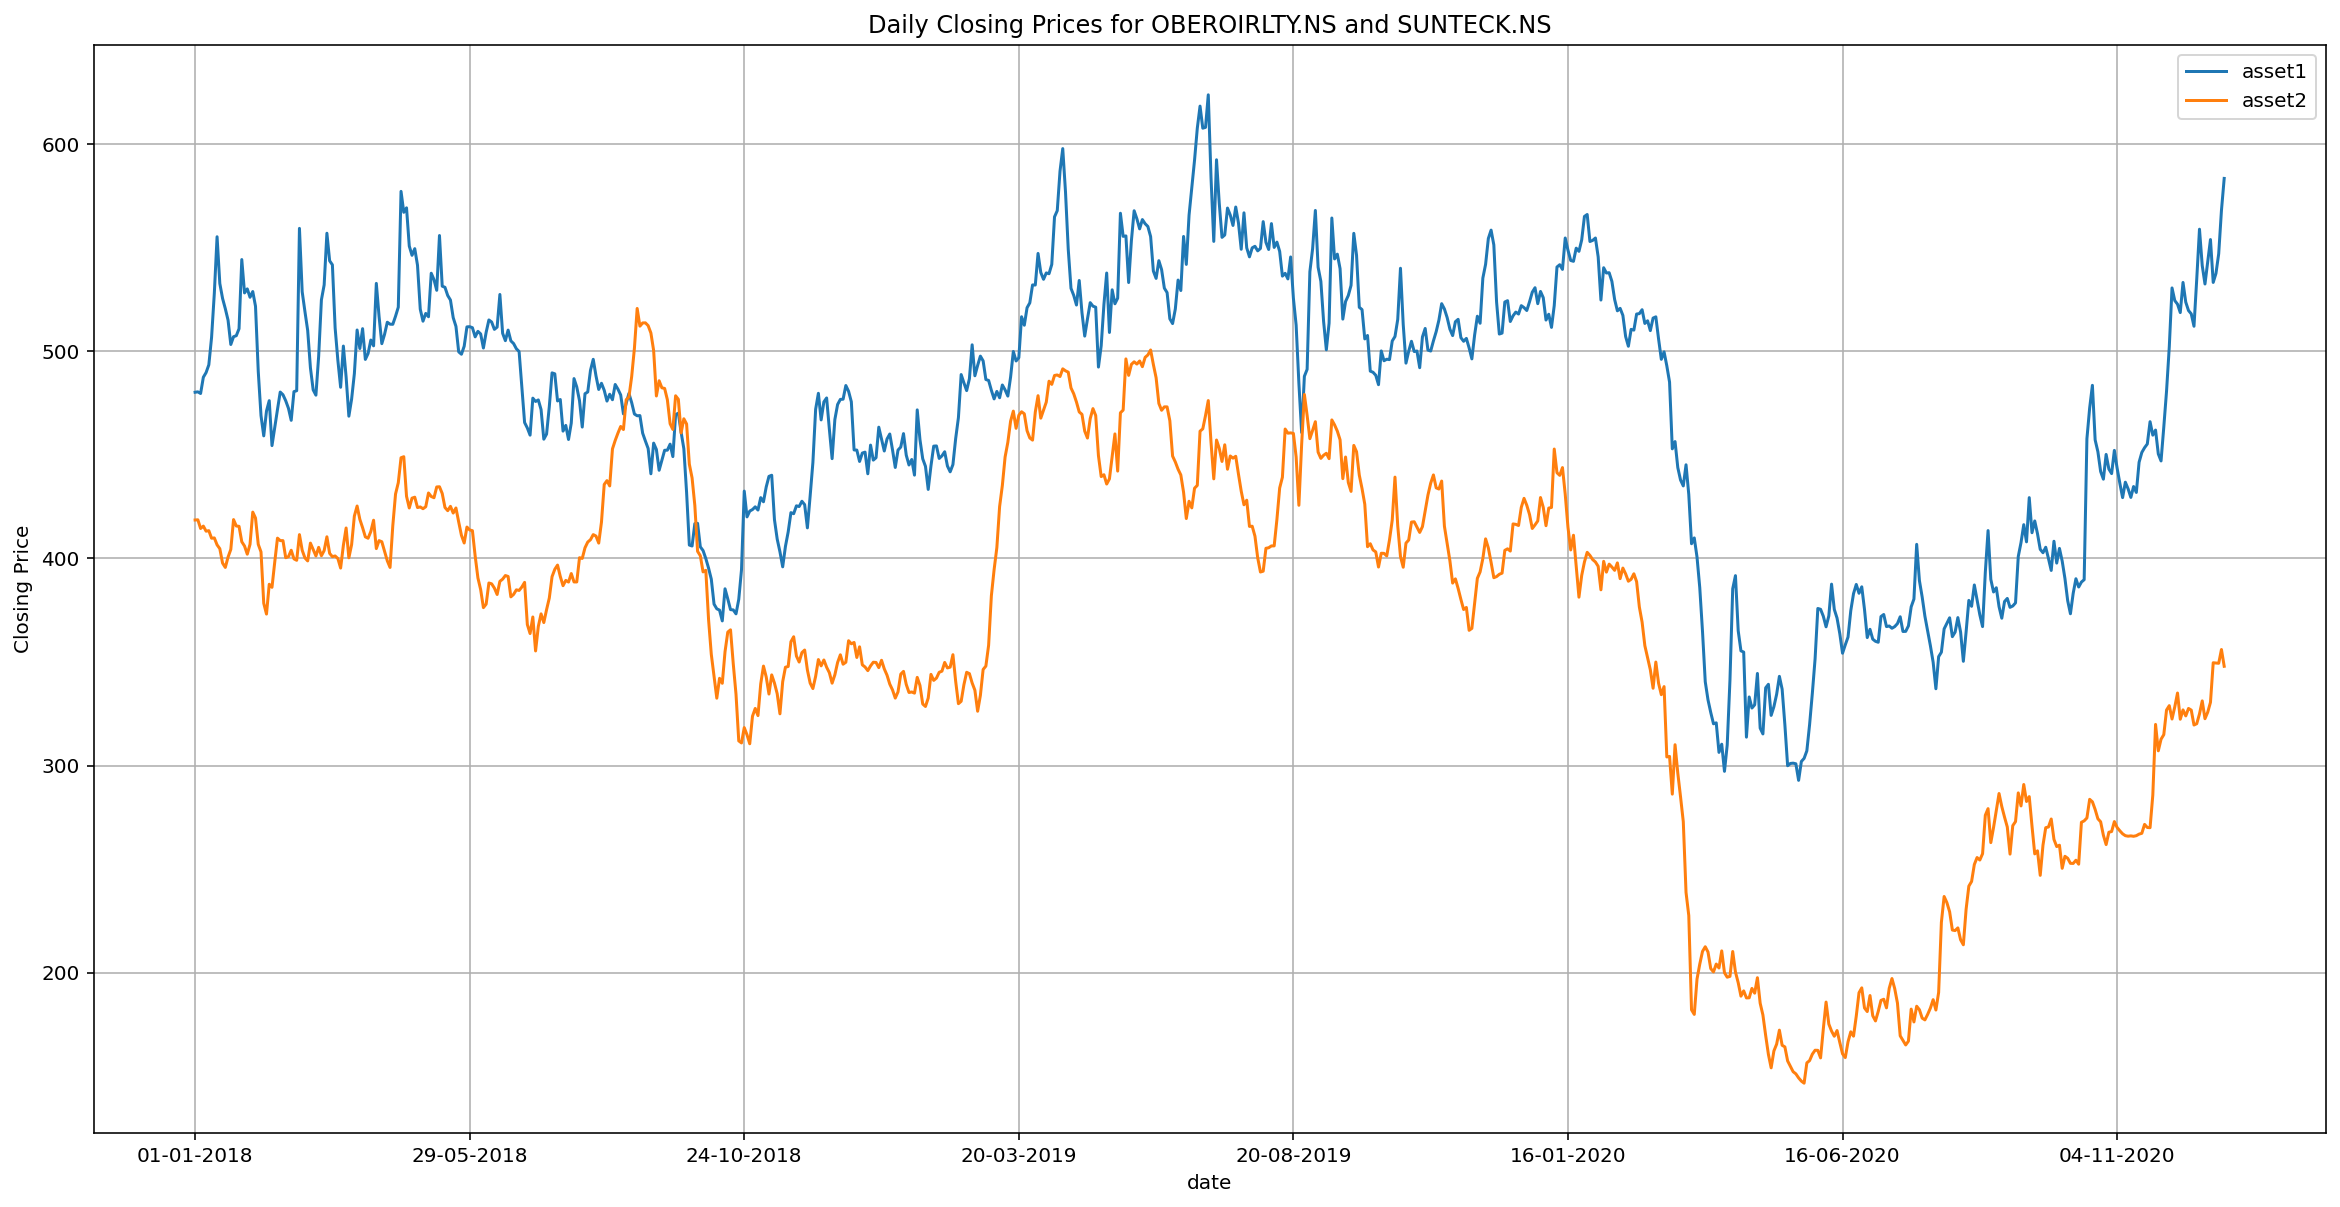

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          3.109e+04
Date:                Tue, 22 Mar 2022   Prob (F-statistic):                        0.00
Time:                        20:44:40   Log-Likelihood:                         -4038.9
No. Observations:                 740   AIC:                                      8080.
Df Residuals:                     739   BIC:                                      8084.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.7717      0.004    176.323      0.000       0.763       0.780
==============================================================================
Omnibus:                        0.150   Durbin-Watson:                   0.040
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.105
Skew:                           0.028   Prob(JB):                        0.949
Kurtosis:                       3.017   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

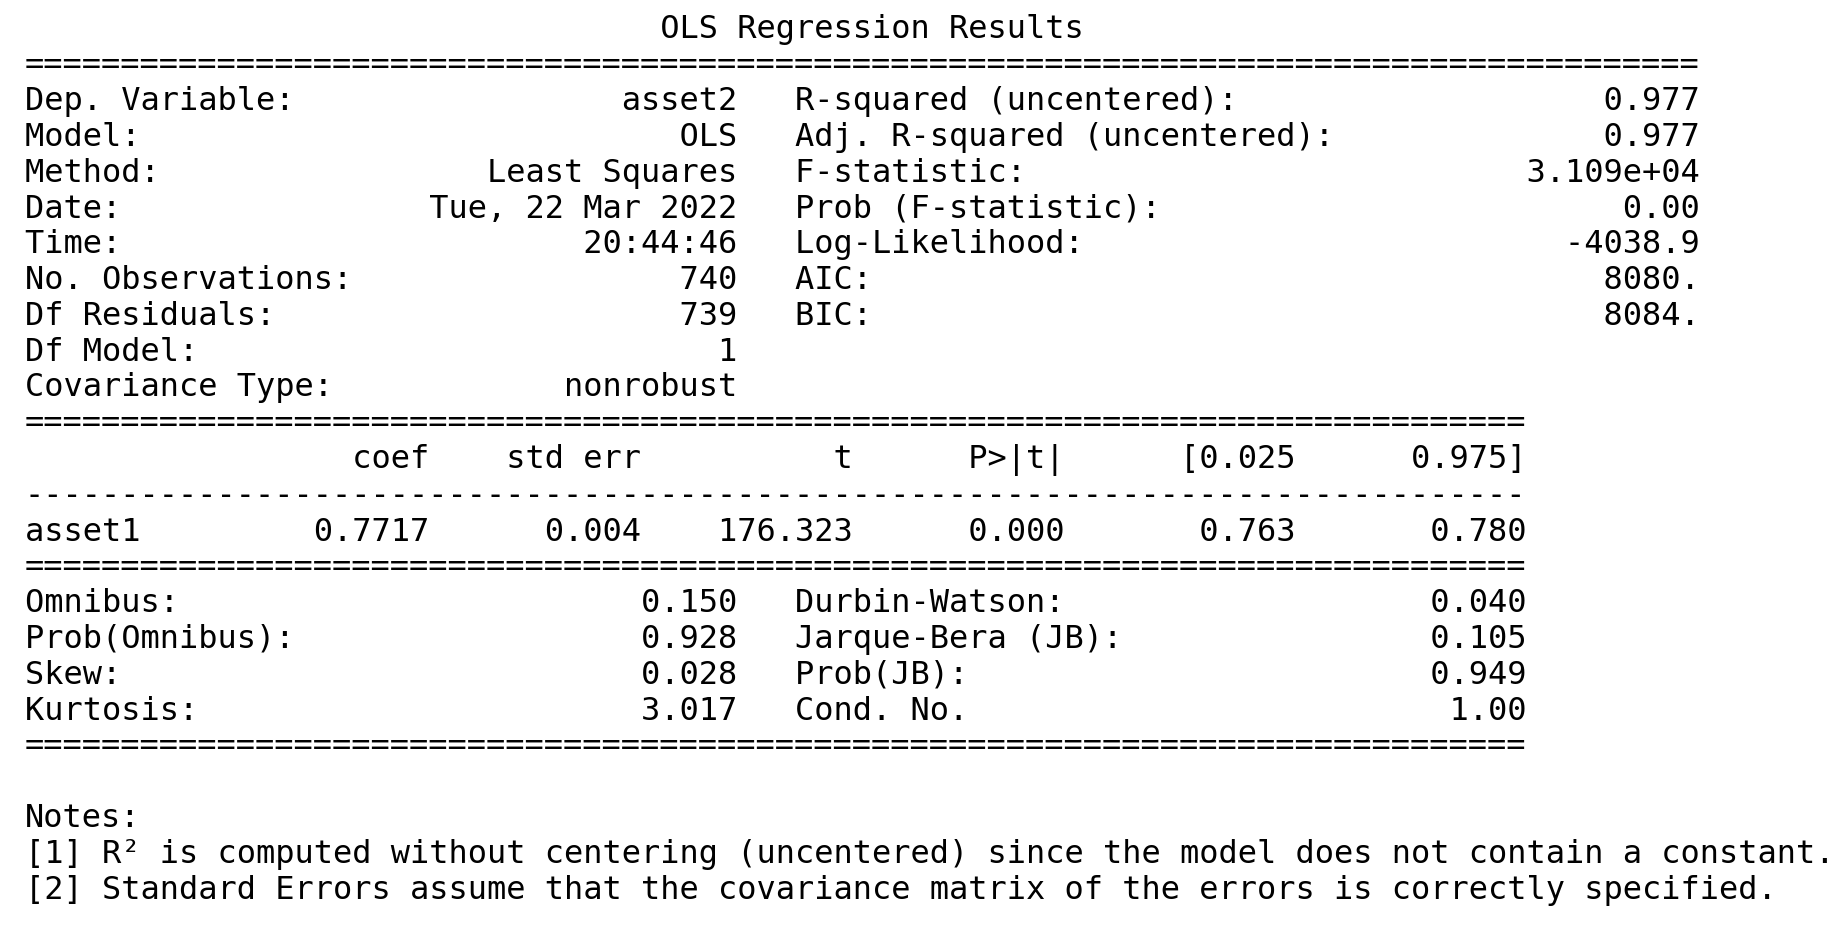

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.7716916647484005


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

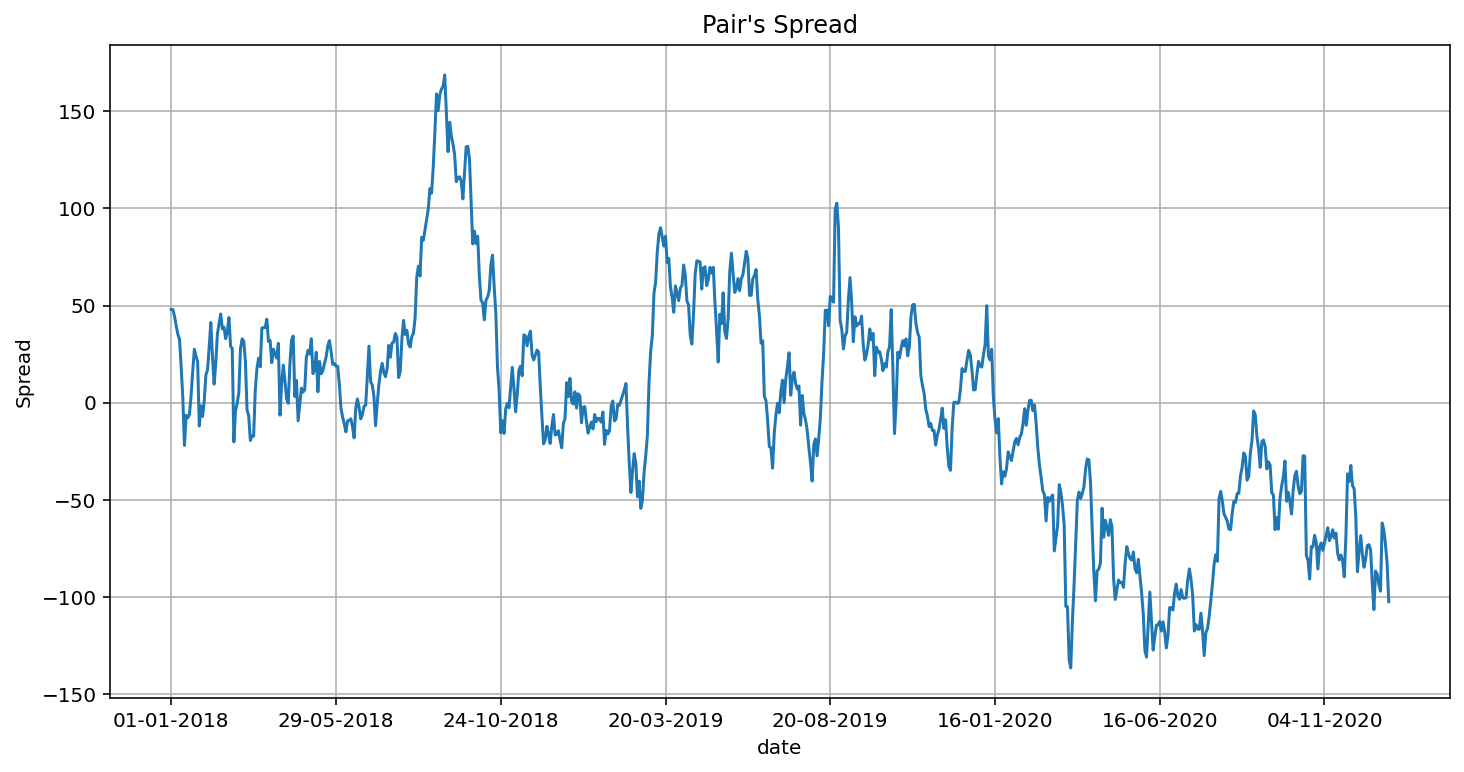

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.81311574683998,
 0.05642456289650942,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 5665.887345605662)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.81311574683998


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  590.099976  355.250000
04-01-2021  590.099976  352.799988
05-01-2021  587.250000  355.450012
06-01-2021  587.549988  347.299988
07-01-2021  589.700012  356.799988

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  590.099976  355.250000 -1.205031            1.0           -1.0
04-01-2021  590.099976  352.799988 -1.144598            1.0           -1.0
05-01-2021  587.250000  355.450012 -1.251934            1.0           -1.0
06-01-2021  587.549988  347.299988 -1.044292            1.0           -1.0
07-01-2021  589.700012  356.799988 -1.248708            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

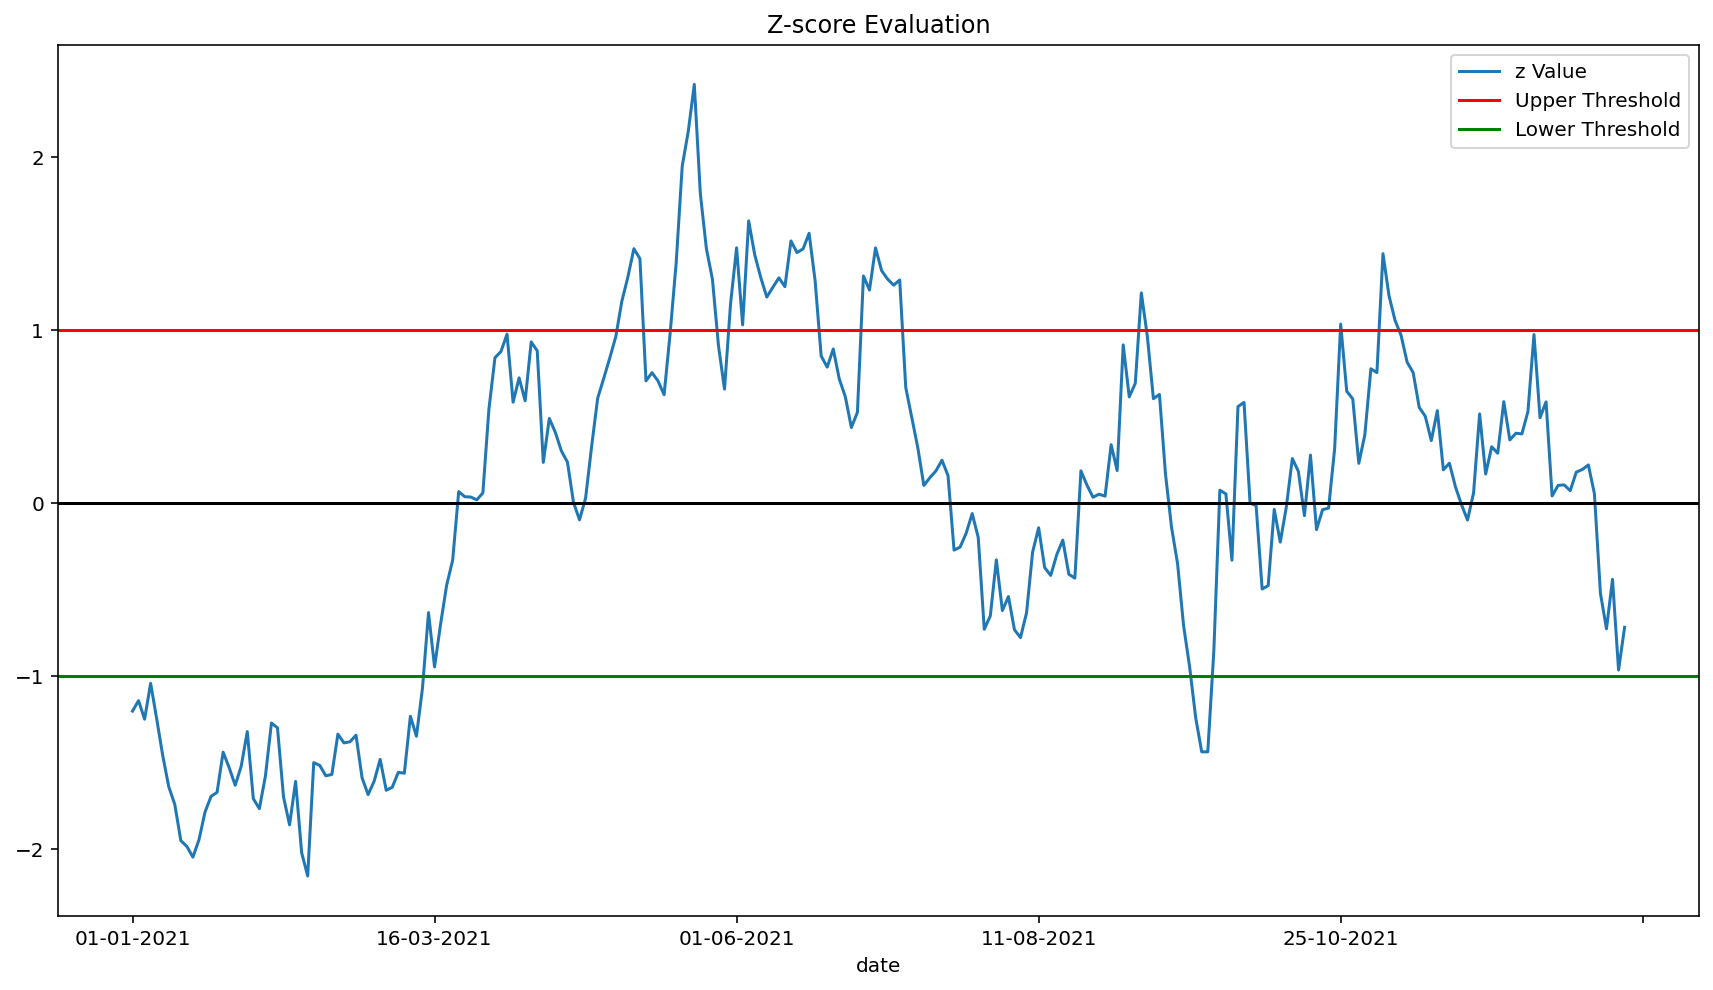

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  590.099976  355.250000 -1.205031            1.0           -1.0   
04-01-2021  590.099976  352.799988 -1.144598            1.0           -1.0   
05-01-2021  587.250000  355.450012 -1.251934            1.0           -1.0   
29-12-2021  866.250000  479.500000 -0.442838            1.0           -1.0   
30-12-2021  846.650024  496.149994 -0.967413            1.0           -1.0   
31-12-2021  861.799988  491.450012 -0.720414            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  590.099976  355.250000 -1.205031            1.0           -1.0   
04-01-2021  590.099976  352.799988 -1.144598            1.0           -1.0   
05-01-2021  587.250000  355.450012 -1.251934            1.0           -1.0   
06-01-2021  587.549988  347.299988 -1.044292            1.0           -1.0   
07-01-2021  589.700012  356.799988 -1.248708            1.0           -1.0   
08-01-2021  590.500000  366.299988 -1.461829            1.0           -1.0   
11-01-2021  585.549988  371.149994 -1.642063            1.0           -1.0   
12-01-2021  595.000000  381.899994 -1.745085            1.0           -1.0   
13-01-2021  580.299988  382.250000 -1.954031            1.0           -1.0   
14-01-2021  579.349976  383.250000 -1.987770            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   590.099976  355.250000 -1.205031            1.0           -1.0   
15-03-2021   596.599976  337.100006 -0.635465            1.0           -1.0   
04-05-2021   552.549988  261.450012  1.164666            1.0           -1.0   
10-05-2021   543.599976  268.350006  0.705245            1.0           -1.0   
18-05-2021   547.299988  253.850006  1.387803            1.0           -1.0   
23-09-2021   847.299988  490.600006 -0.859337            1.0           -1.0   
25-10-2021   908.000000  434.799988  1.033224            1.0           -1.0   
26-10-2021   940.349976  466.850006  0.645163            1.0           -1.0   
03-11-2021  1035.500000  478.049988  1.440684            1.0           -1.0   
09-11-2021  1014.049988  488.500000  0.967883            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
15-03-2021         0        -1.0         0         1.0  
04-05-2021        -1        -1.0         1         1.0  
10-05-2021         0         1.0         0        -1.0  
18-05-2021        -1        -1.0         1         1.0  
23-09-2021         0        -1.0         0         1.0  
25-10-2021        -1        -1.0         1         1.0  
26-10-2021         0         1.0         0        -1.0  
03-11-2021        -1        -1.0         1         1.0  
09-11-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

543.599976     1
588.599976     1
622.200012     1
670.549988     1
791.750000     1
717.549988     1
940.349976     1
1014.049988    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  590.099976  355.250000 -1.205031            1.0           -1.0   
04-01-2021  590.099976  352.799988 -1.144598            1.0           -1.0   
05-01-2021  587.250000  355.450012 -1.251934            1.0           -1.0   
06-01-2021  587.549988  347.299988 -1.044292            1.0           -1.0   
07-01-2021  589.700012  356.799988 -1.248708            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  863.750000  482.250000 -0.523967            1.0           -1.0   
28-12-2021  864.750000  493.600006 -0.729119            1.0           -1.0   
29-12-2021  866.250000  479.500000 -0.442838            1.0           -1.0   
30-12-2021  846.650024  496.149994 -0.967413            1.0           -1.0   
31-12-2021  861.799988  491.450012 -0.720414            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

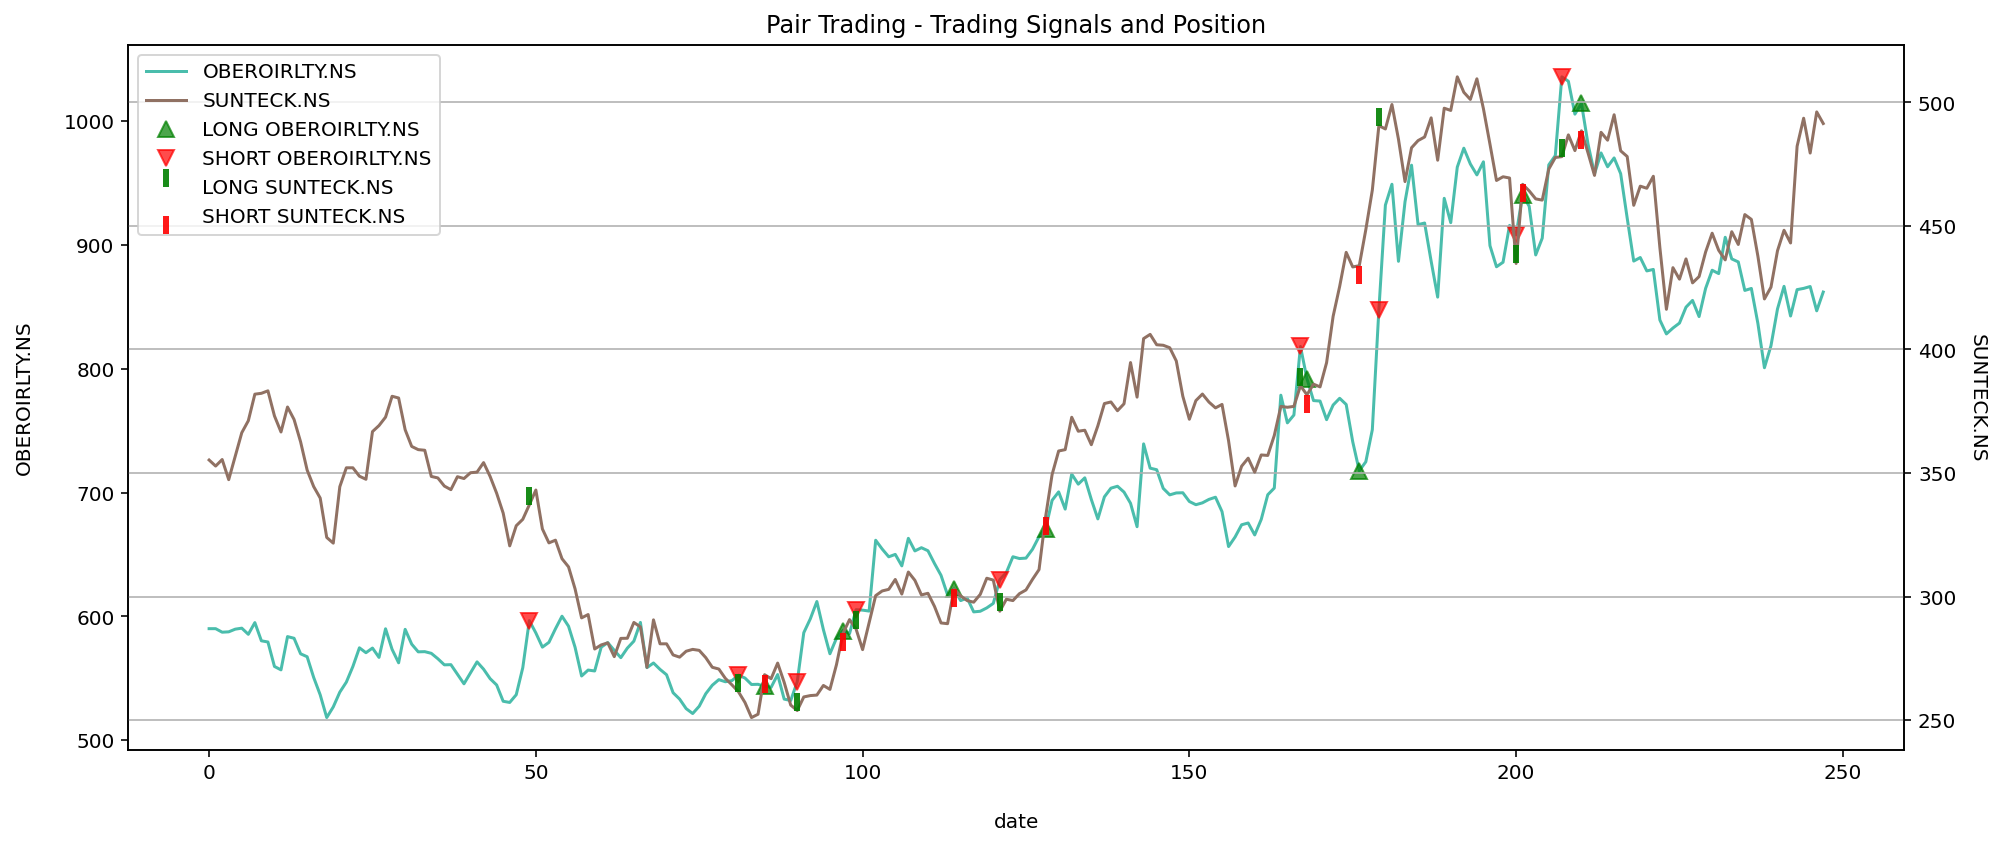

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    590.099976           NaN            NaN            NaN       NaN   
1    590.099976      0.000000  100000.000000  100000.000000       NaN   
2    587.250000      0.000000  100000.000000  100000.000000  0.000000   
3    587.549988      0.000000  100000.000000  100000.000000  0.000000   
4    589.700012      0.000000  100000.000000  100000.000000  0.000000   
243  863.750000 -82920.000000  162558.408179   79638.408179 -0.025033   
244  864.750000 -83016.000000  162558.408179   79542.408179 -0.001205   
245  866.250000 -83160.000000  162558.408179   79398.408179 -0.001810   
246  846.650024 -81278.402342  162558.408179   81280.005837  0.023698   
247  861.799988 -82732.798829  162558.408179   79825.609350 -0.017894   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1          cash1   total asset1       return1  \
0   590.099976            NaN            NaN            NaN           NaN   
49  596.599976  -57273.597658  157273.597658  100000.000000  2.220446e-16   
81  552.549988 -106089.597658  210318.396486  104228.798829 -4.036232e-03   
85  543.599976  -52185.597658  158132.798829  105947.201171  2.908056e-03   
90  547.299988 -105081.597658  210673.597658  105592.000000 -1.363087e-02   

    positions1  
0          NaN  
49        -1.0  
81        -1.0  
85         1.0  
90        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    590.099976           NaN            NaN            NaN       NaN   
1    590.099976      0.000000  100000.000000  100000.000000       NaN   
2    587.250000      0.000000  100000.000000  100000.000000  0.000000   
3    587.549988      0.000000  100000.000000  100000.000000  0.000000   
4    589.700012      0.000000  100000.000000  100000.000000  0.000000   
243  863.750000 -82920.000000  162558.408179   79638.408179 -0.025033   
244  864.750000 -83016.000000  162558.408179   79542.408179 -0.001205   
245  866.250000 -83160.000000  162558.408179   79398.408179 -0.001810   
246  846.650024 -81278.402342  162558.408179   81280.005837  0.023698   
247  861.799988 -82732.798829  162558.408179   79825.609350 -0.017894   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  355.250000           NaN            NaN            NaN   
1           0.0  352.799988      0.000000  100000.000000  100000.000000   
2           0.0  355.450012      0.000000  100000.000000  100000.000000   
3           0.0  347.299988      0.000000  100000.000000  100000.000000   
4           0.0  356.799988      0.000000  100000.000000  100000.000000   
243         0.0  482.250000  94038.750000   48822.253569  142861.003569   
244         0.0  493.600006  96252.001189   48822.253569  145074.254758   
245         0.0  479.500000  93502.500000   48822.253569  142324.753569   
246         0.0  496.149994  96749.248811   48822.253569  145571.502379   
247         0.0  491.450012  95832.752379   48822.253569  144655.005948   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.056455         0.0  
244  0.015492         0.0  
245 -0.018952         0.0  
246  0.022812         0.0  
247 -0.006296         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1          cash1   total asset1       return1  \
0   590.099976            NaN            NaN            NaN           NaN   
49  596.599976  -57273.597658  157273.597658  100000.000000  2.220446e-16   
81  552.549988 -106089.597658  210318.396486  104228.798829 -4.036232e-03   
85  543.599976  -52185.597658  158132.798829  105947.201171  2.908056e-03   
90  547.299988 -105081.597658  210673.597658  105592.000000 -1.363087e-02   

    positions1      asset2      holdings2         cash2   total asset2  \
0          NaN  355.250000            NaN           NaN            NaN   
49        -1.0  337.100006   65734.501189  34265.498811  100000.000000   
81        -1.0  261.450012  101965.504758 -16717.253568   85248.251190   
85         1.0  268.350006   52328.251189  35610.997621   87939.248810   
90        -1.0  253.850006   99001.502379 -13889.753568   85111.748811   

     return2  positions2  
0        NaN         NaN  
49  0.000000         1.0  
81 -0.006364         1.0  
85  0.076378        -1.0  
90 -0.005015         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

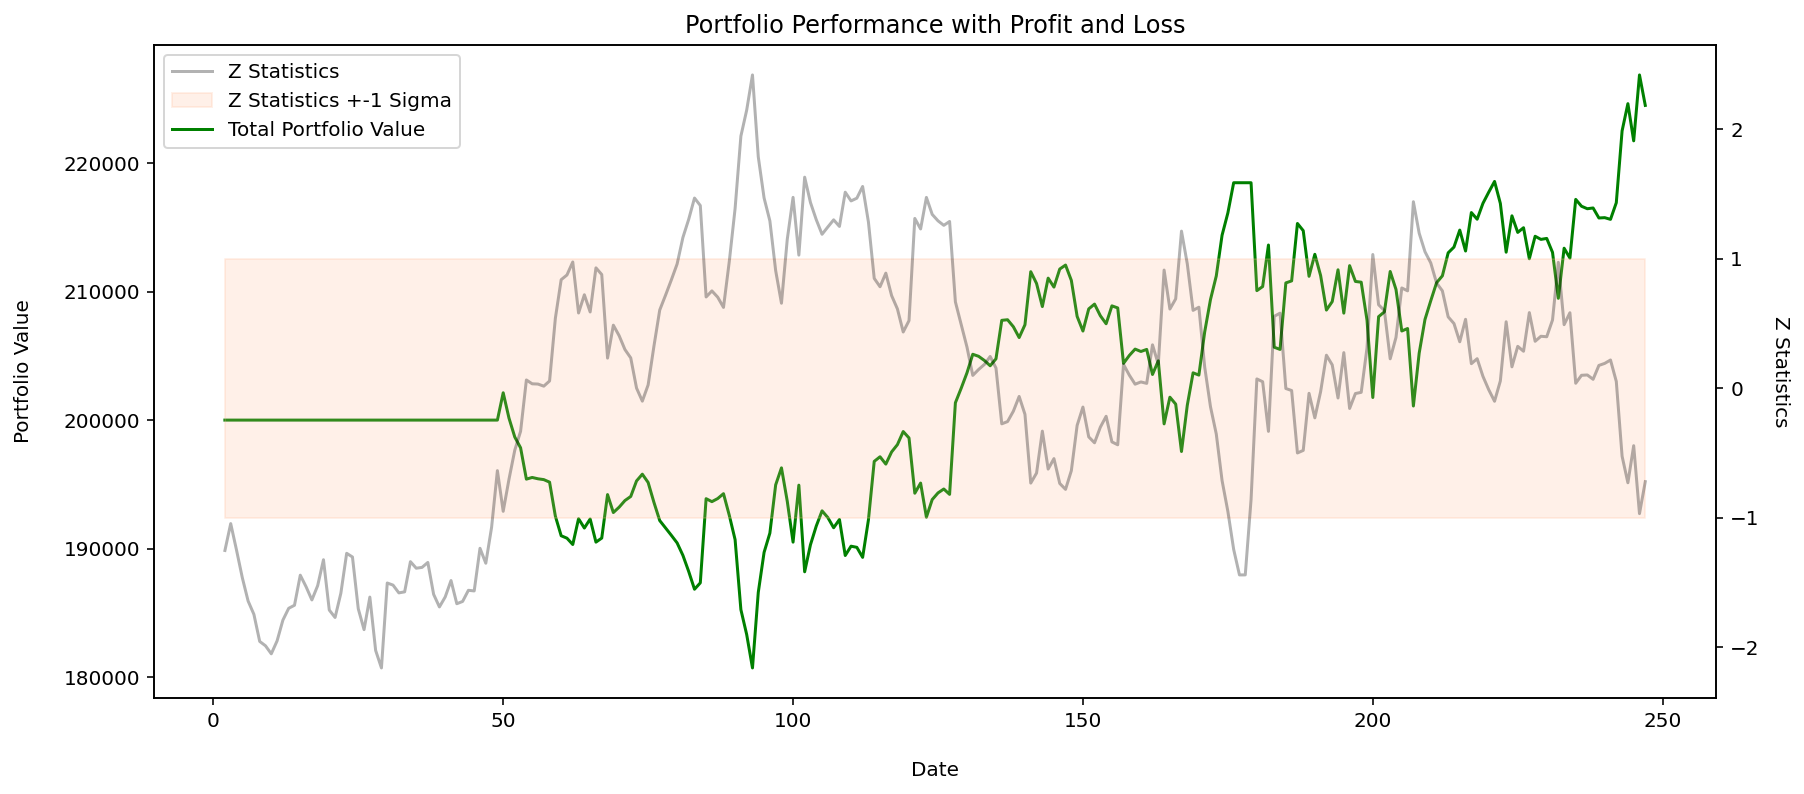

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

224480.61529790002

In [46]:
profit = final_portfolio - 2*initial_capital
profit

24480.615297900018

In [47]:
roi = (profit/(2*initial_capital))*100
roi

12.24030764895001

In [48]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [49]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 233.568%
